# lifelines - predictive maintenance

## Importing the libraries

In [8]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Importing the dataset

In [9]:
# pyspark_df = spark.table("sd_bdc_demo.sarima_time_series_forecasting.1_service_now_survival_data")
# pyspark_df.display()
# df = pyspark_df.toPandas()

In [21]:
df = pd.read_csv("2_maintenance_updated_data/2_maintenance_updated_data.csv")


In [11]:
print(df.head())

   lifetime  broken  pressureInd  moistureInd  temperatureInd  \
0        56       0           92          104              96   
1        81       1           72          103              87   
2        60       0           96           77             112   
3        86       1           94          108              72   
4        34       0           97           99             103   

   provider_Provider2  provider_Provider3  provider_Provider4  team_TeamB  \
0                   0                   0                   1           0   
1                   0                   0                   1           0   
2                   0                   0                   0           0   
3                   1                   0                   0           0   
4                   0                   0                   0           1   

   team_TeamC  
0           0  
1           1  
2           0  
3           1  
4           0  


In [12]:
print(df.columns)

Index(['lifetime', 'broken', 'pressureInd', 'moistureInd', 'temperatureInd',
       'provider_Provider2', 'provider_Provider3', 'provider_Provider4',
       'team_TeamB', 'team_TeamC'],
      dtype='object')


In [13]:
print(df.dtypes)

lifetime              int64
broken                int64
pressureInd           int64
moistureInd           int64
temperatureInd        int64
provider_Provider2    int64
provider_Provider3    int64
provider_Provider4    int64
team_TeamB            int64
team_TeamC            int64
dtype: object


In [14]:
print(df.shape)

(1000, 10)


## The Weibull AFT model

In [15]:
from lifelines import WeibullAFTFitter
aft = WeibullAFTFitter()
aft.fit(df, duration_col='lifetime', event_col='broken')

<lifelines.WeibullAFTFitter: fitted with 1000 total observations, 603 right-censored observations>

In [16]:
aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 1000 total observations, 603 right-censored observations>
             duration col = 'lifetime'
                event col = 'broken'
   number of observations = 1000
number of events observed = 397
           log-likelihood = -64.15
         time fit was run = 2025-06-24 06:32:04 UTC

---
                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                           
lambda_ moistureInd         0.00      1.00      0.00            0.00            0.00                1.00                1.00
        pressureInd        -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
        provider_Provider2  0.15      1.16      0.00            0.15            0.15                1.16                1.16
        provider_Provider3 -0.20      0.82      0.00           -0.20           -0.20                0.82                0.82
        provider_Provider4  0.10      1.10      0.00            0.10            0.10                1.10                1.10
        team_TeamB         -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
        team_TeamC         -0.08      0.92      0.00           -0.08           -0.08                0.92                0.92
        temperatureInd     -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
        Intercept           4.39     80.60      0.00            4.39            4.39               80.25               80.96
rho_    Intercept           5.72    306.29      0.04            5.65            5.80              284.45              329.82

                            cmp to       z      p  -log2(p)
param   covariate                                          
lambda_ moistureInd           0.00    6.09 <0.005     29.68
        pressureInd           0.00   -2.09   0.04      4.76
        provider_Provider2    0.00  321.87 <0.005       inf
        provider_Provider3    0.00 -465.23 <0.005       inf
        provider_Provider4    0.00  199.47 <0.005       inf
        team_TeamB            0.00   -2.08   0.04      4.74
        team_TeamC            0.00 -191.13 <0.005       inf
        temperatureInd        0.00  -21.96 <0.005    352.64
        Intercept             0.00 1965.38 <0.005       inf
rho_    Intercept             0.00  151.64 <0.005       inf
---
Concordance = 1.00
AIC = 148.31
log-likelihood ratio test = 2960.95 on 8 df
-log2(p) of ll-ratio test = inf

In [17]:
print(aft.median_survival_time_)
print(aft.mean_survival_time_)

79.85781384102552
79.80359634313356


### Saving summary table

In [33]:
summary_df = aft.summary.copy()
summary_df = summary_df.reset_index()
summary_df = summary_df.rename(columns={"index": "Parameter"})



In [34]:
# Create the folder if it doesn't exist
os.makedirs("3_1_maintenance_aft_model_summary_data", exist_ok=True)

# Save the Excel file inside the folder
summary_df.to_csv("3_1_maintenance_aft_model_summary_data/3_1_maintenance_aft_model_summary_data.csv", index=False)

### Saving meta data

In [31]:
meta_info = {
    "Model": str(type(aft)),
    "Duration column": 'lifetime',
    "Event column": 'broken',
    "Number of observations": df.shape[0],
    "Number of events observed": df['broken'].sum(),
    "Log-likelihood": aft.log_likelihood_,
    "Concordance": aft.concordance_index_,
    "AIC": aft.AIC_,
    "LLR test": aft.log_likelihood_ratio_test().test_statistic,
    "LLR df": aft.log_likelihood_ratio_test().degrees_freedom,
    "-log2(p) of LLR": -np.log2(aft.log_likelihood_ratio_test().p_value)
}

# Convert to DataFrame
meta_df = pd.DataFrame(list(meta_info.items()), columns=["Metric", "Value"])

C:\Users\LakshmanNavaneethakr\AppData\Local\Temp\ipykernel_23568\927569698.py:12: RuntimeWarning: divide by zero encountered in log2
  "-log2(p) of LLR": -np.log2(aft.log_likelihood_ratio_test().p_value)


In [32]:
# Create the folder if it doesn't exist
os.makedirs("3_2_maintenance_aft_model_meta_data", exist_ok=True)

# Save the Excel file inside the folder
meta_df.to_csv("3_2_maintenance_aft_model_meta_data/3_2_maintenance_aft_model_meta_data.csv", index=False)

## Plotting

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

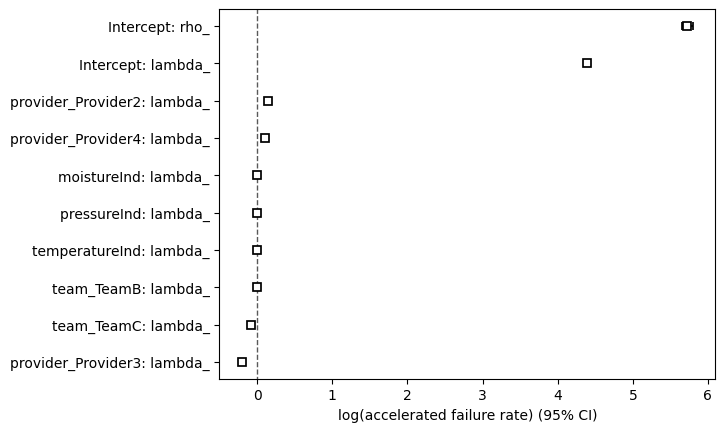

In [18]:
from matplotlib import pyplot as plt

aft.plot()

## Prediction

In [23]:
X = df.loc[:10]

aft.predict_cumulative_hazard(X, ancillary=X)
aft.predict_survival_function(X, ancillary=X)
aft.predict_median(X, ancillary=X)
aft.predict_percentile(X, p=0.9, ancillary=X)
aft.predict_expectation(X, ancillary=X)

0     88.089455
1     81.417784
2     79.449244
3     85.934844
4     79.694951
5     80.108581
6     91.719151
7     65.052447
8     92.764149
9     81.232063
10    88.104920
dtype: float64

## Save the table